In [3]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv, MAX_ACCOUNT_BALANCE
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.utils import misc
from dcc import Parameters, AAV, OAV


import numpy as np
import pickle
import copy
from itertools import product

from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt

# import policy_pricer_python
# from policy_pricer.cython_pricer import cython_pricer_naive
# from policy_pricer import pricer_naive
# from policy_pricer.cython_pricer import cython_pricer_optimized

ImportError: cannot import name 'cython_pricer_optimized' from 'policy_pricer' (..\policy_pricer\__init__.py)

In [3]:
params = Parameters()
aav = AAV(params)
sample_acc = np.array([5., 200])
aav.u(sample_acc[0], sample_acc[1])

[INFO] [2021-04-18 18:39:48,998] [AAV] - Instantiated @ AAV


-193.46379389522158

In [4]:
def convert_params_obj(params):
    retarr = np.array([params.lambdainf, params.kappa, params.delta10, params.delta11, params.delta2, params.c, params.rho], dtype=np.float64)
    return retarr

In [5]:
c_params = convert_params_obj(params)
c_params

array([ 0.1 ,  0.7 ,  0.02,  0.5 ,  1.  , 10.  ,  0.06])

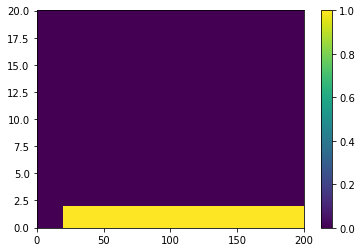

In [6]:
l = np.linspace(0, 20, 500)
w = np.linspace(0, 200, 500)
ww, ll = np.meshgrid(w, l)

autonomous_p = np.zeros_like(ww,dtype='int64')
degenerate_p = autonomous_p.copy()
# degenerate_p[:, 300:] = 1
degenerate_p[:50, 50:] = 1
plt.pcolormesh(ww, ll, degenerate_p, shading='auto')
plt.colorbar()
plt.show()

In [7]:
params.c = 40
c_params = convert_params_obj(params)
c_params


array([1.e-01, 7.e-01, 2.e-02, 5.e-01, 1.e+00, 4.e+01, 6.e-02])

Profile the my_search sorted function, based on a binary search

In [8]:
ar = np.arange(0, 500., 7)
target = 600

print(cython_pricer_optimized.mySearchSorted_callable(ar, target))
print(np.searchsorted(ar, target, side='right'))
print(np.digitize(target, ar, right=True))

72
72
72


In [9]:
%%timeit
cython_pricer_optimized.mySearchSorted_callable(ar, target)

377 ns ± 3.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [10]:
%%timeit
np.searchsorted(ar, target, side='right')

1.93 µs ± 8.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [11]:
%%timeit
np.digitize(target, ar, right=True)

4.95 µs ± 10.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Profiling account value function

In [12]:
%%timeit
np.asarray(cython_pricer_optimized.value_account(sample_acc, ww, ll, autonomous_p, c_params, np.array([0, 0.2]), n_iterations=10000))

23 ms ± 83.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit
np.mean(cython_pricer_optimized.value_account_paral(sample_acc, ww, ll, autonomous_p, c_params, np.array([0, 0.2]), n_iterations=10000))

349 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%%timeit
np.mean(cython_pricer_naive.value_account(sample_acc, ww, ll, autonomous_p, c_params, np.array([0, 0.2]), n_iterations=10000))

881 ms ± 8.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
np.mean(policy_pricer_python.value_account(sample_acc, ww, ll, autonomous_p, params, np.array([0, 0.2]), n_iterations=10000))

1.52 s ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Timing the single collection cycle

In [14]:
%%timeit
cython_pricer_optimized.single_collection(sample_acc, ww, ll, autonomous_p, c_params, np.array([0, 0.2]))

5.03 µs ± 30.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [15]:
%%timeit
cython_pricer_naive.single_collection(sample_acc, ww, ll, autonomous_p, c_params, np.array([0, 0.2]))

89 µs ± 485 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
%%timeit
policy_pricer_python.single_collection(sample_acc, ww, ll, autonomous_p, params, np.array([0, 0.2]))

152 µs ± 1.01 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
